In [1]:
print("retest")

# FOLD = '/content/'
FOLD = '/kaggle/working/'
import os


retest


In [2]:
import shutil

# Function to remove a folder and its contents
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Folder {path} and its contents successfully removed.")
    except OSError as e:
        print(f"Error: {e.strerror}")

# Specify the path of the folder to be removed
folder_path = os.path.join(FOLD, 'dataset')

# Call the function to remove the folder
remove_folder(folder_path)


Error: No such file or directory


In [3]:
!git clone https://github.com/QuanHoangNgoc/Container.git dataset

Cloning into 'dataset'...
remote: Enumerating objects: 6739, done.
remote: Total 6739 (delta 0), reused 0 (delta 0), pack-reused 6739
Receiving objects: 100% (6739/6739), 140.80 MiB | 32.01 MiB/s, done.
Updating files: 100% (7024/7024), done.


In [4]:
DIR = '/kaggle/input/brain-tumor-detection/'
os.listdir(DIR)


['no', 'yes', 'Br35H-Mask-RCNN', 'pred']

# Demo

## --List Files

In [14]:
YES = '/kaggle/working/dataset/Testing/glioma/'
NO = '/kaggle/working/dataset/Testing/notumor/'
list_of_class = [os.path.join(YES, x) for x in os.listdir(YES)[:5]] 
list_of_class2 = [os.path.join(NO, x) for x in os.listdir(NO)[:5]] 
print(list_of_class)
list_of_class.extend(list_of_class2)
print(list_of_class)


['/kaggle/working/dataset/Testing/glioma/Te-gl_0169.jpg', '/kaggle/working/dataset/Testing/glioma/Te-gl_0190.jpg', '/kaggle/working/dataset/Testing/glioma/Te-glTr_0003.jpg', '/kaggle/working/dataset/Testing/glioma/Te-glTr_0008.jpg', '/kaggle/working/dataset/Testing/glioma/Te-gl_0018.jpg']
['/kaggle/working/dataset/Testing/glioma/Te-gl_0169.jpg', '/kaggle/working/dataset/Testing/glioma/Te-gl_0190.jpg', '/kaggle/working/dataset/Testing/glioma/Te-glTr_0003.jpg', '/kaggle/working/dataset/Testing/glioma/Te-glTr_0008.jpg', '/kaggle/working/dataset/Testing/glioma/Te-gl_0018.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0311.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0144.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0209.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0229.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0322.jpg']


In [15]:
list_of_loc = ['/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TEST/y701.jpg',
'/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TEST/y702.jpg',
'/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TEST/y703.jpg'
]


## --Load Model

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random


# Define the network architecture
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        
        # Dense layers
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(state_size, 512), # vector instead of image 
            nn.ELU(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, action_size)
        )
        
        # Initialize the weights using Glorot uniform initialization
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.dense_layers(x)
        return x


In [17]:
HOG = 30276
class_model = QNetwork(HOG, 2)
loc_model = QNetwork(HOG, 16)
class_model.load_state_dict(torch.load('/kaggle/input/load-model/DDQN_qnetwork_local.pth'))
loc_model.load_state_dict(torch.load('/kaggle/input/load-model/DDQN_qnetwork_local_loc.pth'))
print(class_model)
print(loc_model)


QNetwork(
  (dense_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30276, out_features=512, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=2, bias=True)
  )
)
QNetwork(
  (dense_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30276, out_features=512, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=16, bias=True)
  )
)


## --Read and Hog image 

In [18]:
import skimage as ski
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import math


example_code = True 
if (example_code):
    print("ski version: ", ski.__version__)
    print("numpy version: ", np.__version__)
    print("pandas version: ", pd.__version__)
    print("sklearn version: ", skl.__version__)
        

ski version:  0.22.0
numpy version:  1.26.4
pandas version:  2.2.2
sklearn version:  1.2.2


In [19]:
######################################################################################################
# SKI UTIL
######################################################################################################
def retype_image(image: np.ndarray, istype: str):
    if (istype not in ['float', 'ubyte', 'int']):
        ut.error()
    if (istype == 'float'):
        return ski.util.img_as_float(image)
    if (istype == 'ubyte'):
        return ski.util.img_as_ubyte(image)
    if (istype == 'int'):
        return ski.util.img_as_int(image)
    ut.error()


def revalue_image(image, in_range, out_range):
    return ski.exposure.rescale_intensity(image, in_range=in_range, out_range=out_range)


def show_image(image: np.ndarray, choose=1):
    try:
        assert (choose == 0)
        out = ski.util.img_as_uint(image) # Convert to int
        plt.imshow(out)
        plt.axis('off')  # Optional: to hide the axis
        plt.show()
    except:
        # Display the image using skimage's viewer
        out = ski.util.img_as_uint(image) # Convert to int
        print('cmap = gray')
        plt.imshow(out, cmap='gray')
        plt.axis('off')  # Optional: to hide the axis
        plt.show()


def read_image(path: str, as_gray=True):
    image = ski.io.imread(path, as_gray=as_gray)
    image = ski.img_as_float(image)
    return image

def recolor_image(image, channel):
    if (channel not in ['gray', 'rgb']):
        ut.error()
    if (channel == 'gray'):
        return ski.color.rgb2gray(image)
    if (channel == 'rgb'):
        return ski.color.gray2rgb(image)
    ut.error()


def show_his(image):
    try:
        colors = ('red', 'green', 'blue')
        for color, channel in zip(colors, image.transpose((2, 0, 1))):
            hist, hist_centers = exposure.histogram(channel)
#             hist /= len(hist.flatten())
            plt.fill_between(hist_centers, hist, label=color, alpha=0.3)
        plt.legend()
        plt.title('Histogram for Each Color Channel')
    except:
        # Compute the histogram
        hist, hist_centers = exposure.histogram(image)
#         hist /= len(hist.flatten())
        # Display the histogram
        plt.fill_between(hist_centers, hist, alpha=0.3)
        plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
    plt.show()


In [20]:
from skimage import color, io
import cv2
from skimage.feature import hog


SIZE = (240, 240, 3)
VALUE = 'ubyte'
orientations = 9   # Number of gradient orientations
pixels_per_cell = (8, 8)  # Size of a cell in pixels
cells_per_block = (2, 2)  # Number of cells per block


def get_image(path): 
    org_image = io.imread(path) # Color 
    # Resize image -> Retype image 
    org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
    org_image = retype_image(org_image, 'ubyte')
    
    x = org_image.copy() 
    gray_image = color.rgb2gray(x)
    hog_features, hog_image = hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, visualize=True)
    return org_image, hog_features
    

In [21]:
def get_act(action_values): 
    return np.argmax(action_values.cpu().data.numpy())
    

In [22]:
C = 4
B = 240 // C 

cen_label = [None for i in range(C*C)] 
for i in range(C): 
    for j in range(C): 
        cen_label[i*C + j] = [i*B + B//2, j*B + B//2]

cen_label = np.array(cen_label)


THRES = float(3200.0)
def sqr2points(a, b): 
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 


cen_label


array([[ 30,  30],
       [ 30,  90],
       [ 30, 150],
       [ 30, 210],
       [ 90,  30],
       [ 90,  90],
       [ 90, 150],
       [ 90, 210],
       [150,  30],
       [150,  90],
       [150, 150],
       [150, 210],
       [210,  30],
       [210,  90],
       [210, 150],
       [210, 210]])

In [23]:
LABEL = ["NO", "YES"]


['/kaggle/working/dataset/Testing/glioma/Te-gl_0169.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0229.jpg', '/kaggle/working/dataset/Testing/glioma/Te-gl_0190.jpg', '/kaggle/working/dataset/Testing/glioma/Te-glTr_0008.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0144.jpg', '/kaggle/working/dataset/Testing/glioma/Te-gl_0018.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0322.jpg', '/kaggle/working/dataset/Testing/glioma/Te-glTr_0003.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0209.jpg', '/kaggle/working/dataset/Testing/notumor/Te-no_0311.jpg']
['/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TEST/y701.jpg', '/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TEST/y702.jpg', '/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/TEST/y703.jpg']

Name of image is:  /kaggle/working/dataset/Testing/glioma/Te-gl_0169.jpg


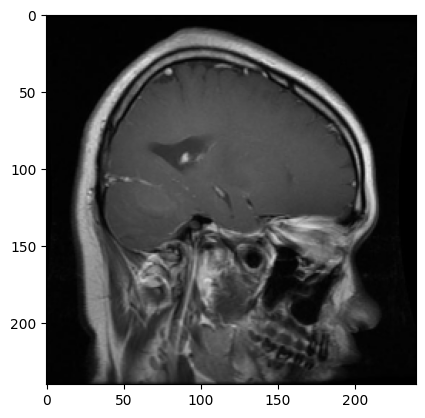

Label prediction of image is:  YES
Center prediction of tumor is:  [150 150]
True label:  Yestumor


In [40]:
random.shuffle(list_of_class)
random.shuffle(list_of_loc)
print(list_of_class)
print(list_of_loc)
print() 
path = list_of_class[0]
print("Name of image is: ", path)


image, state = get_image(path)
plt.imshow(image)
plt.show()

state_torch = torch.from_numpy(state).float().unsqueeze(0)
label = get_act(class_model(state_torch))
center = get_act(loc_model(state_torch))

label = LABEL[label]
center = cen_label[center]
if(label == "NO"): 
    center = [-1, -1]


print("Label prediction of image is: ", label)
print("Center prediction of tumor is: ", center)
true_label = "Yestumor"
if(path.find("notumor") != -1): true_label = "Notumor"
print("True label: ", true_label)
